In [24]:
# Core imports
from mycore import ast2station_rotating, ast2station_rotating2

# PyTorch and ML
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Main imports
import heyoka as hy
import pykep as pk
import pandas as pd

# Usual imports
import time
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import copy

# Jupyter setup
%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the dataset
The file nominal_bundle....pk is created in the previous notebook


In [25]:
dataset_name="data/training_50000_100_[0.001, 0.001, 0.08, 0.08]_[1.0, 1.0, 1.0, 1.0].pk"
with open(dataset_name, "rb") as file:
    data = pkl.load(file)
np.random.shuffle(data)

In [26]:
if torch.cuda.is_available():
    print("PyTorch detected CUDA")
    device = torch.device("cuda:2")
else: 
    print("PyTorch DIN NOT detect CUDA")
    device = torch.device("cpu")
print("Training on :", device)

PyTorch detected CUDA
Training on : cuda:2


# Model definition

In [27]:
# A FFNN with continuous activation functions (softplus)
#128 neurons, one less hidden layer
neurons = 128
model = nn.Sequential(
          nn.Linear(6,neurons),
          nn.Softplus(),
          nn.Linear(neurons,neurons),
          nn.Softplus(),  
          nn.Linear(neurons,neurons),
          nn.Softplus(),  
          nn.Linear(neurons,3),
        )

model = model.cuda(device)

# Kaiming_normal initialization method
def initial_weights(m):
    """
    - Initializes weights in each layer according to 'He initialization'.
    Args:
        m   (torch.nn.Linear):         - Neural network layers
    Returns:
        None
    """
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)

# Initialize the weights
_ = model.apply(initial_weights)

display(model)
print("Amount of weights/parameters:", sum([w.numel() for w in model.parameters() if w.requires_grad]))

Sequential(
  (0): Linear(in_features=6, out_features=128, bias=True)
  (1): Softplus(beta=1, threshold=20)
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): Softplus(beta=1, threshold=20)
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): Softplus(beta=1, threshold=20)
  (6): Linear(in_features=128, out_features=3, bias=True)
)

Amount of weights/parameters: 34307


# Dataset split and preparation

In [28]:
# We split the whole dataset into training and testing
X_TRAIN, X_VALIDATION, Y_TRAIN, Y_VALIDATION = train_test_split(data.reshape(-1,10)[:,:6], data.reshape(-1,10)[:,6:9], train_size=0.8)
X_TRAIN = torch.tensor(X_TRAIN, device = device)
X_VALIDATION = torch.tensor(X_VALIDATION, device = device)
Y_TRAIN = torch.tensor(Y_TRAIN, device = device)
Y_VALIDATION = torch.tensor(Y_VALIDATION, device = device)

# Optimizer and Loss

In [29]:
# The loss is the cosine of the angle between the predicted and the actual thrust vector
cosine_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-8)
# This first loss is directly in degrees
def loss1(ground_truth, prediction):    
    return torch.mean(torch.arccos(cosine_similarity(ground_truth, prediction))) / np.pi * 180
# This is the loss used in the paper with Ekin
def loss2(ground_truth, prediction):    
    return 1 - torch.mean(cosine_similarity(ground_truth, prediction))
loss = loss2

# Setup for the optimizer
learning_rate = 1e-4*0.5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10, verbose=True, threshold=0.005, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

# Lists used to plot loss over epochs
loss_list = []
loss_val_list = []

# Training loop

In [30]:
n_epochs = 300
batch_size_train = 4096
batch_size_val = 4096

first = True
start_time = time.time()

# We store the model that suring training obtains the best score on validation
best_model = copy.deepcopy(model)
best_loss = 1e4

print(f'Training batchsize = {batch_size_train}') # Can also be accessed with batchsize = states.shape[0]

for epoch in range(n_epochs):
    if first:
        time_remaining = '-'
    else:
        time_estimate = epoch_time*(n_epochs-epoch+1)
        if time_estimate > 60:
            if time_estimate > 3600:
                time_remaining = str(round(time_estimate/3600,2))+' h'
            else:
                time_remaining = str(round(time_estimate/60,2))+' min'
        else:
            time_remaining = str(round(time_estimate,0))+' s'
        
    first = False
    print(f"Epoch {epoch+1}/{n_epochs}, Current learning rate: {optimizer.state_dict()['param_groups'][0]['lr']}, Time remaining: {'-' if first else time_remaining}")

    start_time_epoch = time.time()
    X_TRAIN, Y_TRAIN = shuffle(X_TRAIN, Y_TRAIN)
    
    # We loop over the entire dataset (ignoring the last incomplete batch)
    for i in tqdm(range(X_TRAIN.shape[0]//batch_size_train)):
        states = X_TRAIN[i*batch_size_train: (i+1)*batch_size_train, :]
        labels = Y_TRAIN[i*batch_size_train: (i+1)*batch_size_train, :]

        # Reset gradients (backward() is cumulative)
        optimizer.zero_grad()
        # Forward pass = prediction
        predictions = model(states.float())

        # Loss
        l = loss(labels, predictions)

        # Backward pass = Gradients (dl/dw)
        l.backward() # Automatically compute the gradient of the loss wrt the weights

        # Update weights
        optimizer.step()
        
    with torch.no_grad():
        # Load random validation batch
        X_VALIDATION, Y_VALIDATION = shuffle(X_TRAIN, Y_TRAIN)
        states_val = X_VALIDATION[:batch_size_val, :]
        labels_val = Y_VALIDATION[:batch_size_val, :]
    
        # Forward pass = prediction
        predictions_val = model(states_val.float())
        
        # Loss
        l_val = loss(labels_val, predictions_val)
        
        if l_val < best_loss:
            best_model = copy.deepcopy(model)
            best_loss = l_val
            print("Updating best model!")
        # Scheduler (reduce learning rate if loss stagnates)
        scheduler.step(l_val)       
    
    # Save values for plots
    loss_list.append(l.item())
    loss_val_list.append(l_val.item())

    print(f'loss = {l:.8f}, loss validation = {l_val:.8f} \n')
    
    epoch_time = (time.time() - start_time_epoch)
    
# Compute excecution time
execution_time = (time.time() - start_time)    
print(f"Total Training Time time: {round(execution_time,2)}s seconds")

Training batchsize = 4096
Epoch 1/300, Current learning rate: 5e-05, Time remaining: -


100%|██████████| 3906/3906 [00:13<00:00, 280.96it/s]


Updating best model!
loss = 0.07214149, loss validation = 0.07350860 

Epoch 2/300, Current learning rate: 5e-05, Time remaining: 1.34 h


100%|██████████| 3906/3906 [00:13<00:00, 287.37it/s]


Updating best model!
loss = 0.05204957, loss validation = 0.05998030 

Epoch 3/300, Current learning rate: 5e-05, Time remaining: 1.28 h


100%|██████████| 3906/3906 [00:13<00:00, 285.62it/s]


Updating best model!
loss = 0.04805789, loss validation = 0.04770515 

Epoch 4/300, Current learning rate: 5e-05, Time remaining: 1.35 h


100%|██████████| 3906/3906 [00:13<00:00, 295.30it/s]


loss = 0.04768579, loss validation = 0.04937642 

Epoch 5/300, Current learning rate: 5e-05, Time remaining: 1.27 h


100%|██████████| 3906/3906 [00:13<00:00, 293.45it/s]


Updating best model!
loss = 0.04747730, loss validation = 0.04279860 

Epoch 6/300, Current learning rate: 5e-05, Time remaining: 1.28 h


100%|██████████| 3906/3906 [00:11<00:00, 354.09it/s]


Updating best model!
loss = 0.04133415, loss validation = 0.04079509 

Epoch 7/300, Current learning rate: 5e-05, Time remaining: 1.05 h


100%|██████████| 3906/3906 [00:10<00:00, 363.94it/s]


loss = 0.04575699, loss validation = 0.04929621 

Epoch 8/300, Current learning rate: 5e-05, Time remaining: 59.33 min


100%|██████████| 3906/3906 [00:10<00:00, 366.58it/s]


loss = 0.03995230, loss validation = 0.04558014 

Epoch 9/300, Current learning rate: 5e-05, Time remaining: 58.62 min


100%|██████████| 3906/3906 [00:10<00:00, 373.95it/s]


loss = 0.04494857, loss validation = 0.04128433 

Epoch 10/300, Current learning rate: 5e-05, Time remaining: 57.35 min


100%|██████████| 3906/3906 [00:10<00:00, 367.71it/s]


Updating best model!
loss = 0.04027929, loss validation = 0.03678854 

Epoch 11/300, Current learning rate: 5e-05, Time remaining: 58.16 min


100%|██████████| 3906/3906 [00:10<00:00, 383.80it/s]


loss = 0.03504928, loss validation = 0.03950282 

Epoch 12/300, Current learning rate: 5e-05, Time remaining: 55.78 min


100%|██████████| 3906/3906 [00:10<00:00, 370.58it/s]


Updating best model!
loss = 0.04235108, loss validation = 0.03582753 

Epoch 13/300, Current learning rate: 5e-05, Time remaining: 57.39 min


100%|██████████| 3906/3906 [00:10<00:00, 359.63it/s]


loss = 0.03776196, loss validation = 0.03644980 

Epoch 14/300, Current learning rate: 5e-05, Time remaining: 58.64 min


100%|██████████| 3906/3906 [00:11<00:00, 353.15it/s]


loss = 0.04234348, loss validation = 0.03663511 

Epoch 15/300, Current learning rate: 5e-05, Time remaining: 59.44 min


100%|██████████| 3906/3906 [00:10<00:00, 356.51it/s]


Updating best model!
loss = 0.03761326, loss validation = 0.03528866 

Epoch 16/300, Current learning rate: 5e-05, Time remaining: 59.12 min


100%|██████████| 3906/3906 [00:11<00:00, 353.51it/s]


loss = 0.03509410, loss validation = 0.03938141 

Epoch 17/300, Current learning rate: 5e-05, Time remaining: 58.93 min


100%|██████████| 3906/3906 [00:11<00:00, 353.42it/s]


Updating best model!
loss = 0.03484381, loss validation = 0.02615760 

Epoch 18/300, Current learning rate: 5e-05, Time remaining: 59.12 min


100%|██████████| 3906/3906 [00:10<00:00, 362.74it/s]


loss = 0.02815920, loss validation = 0.04100339 

Epoch 19/300, Current learning rate: 5e-05, Time remaining: 57.4 min


100%|██████████| 3906/3906 [00:10<00:00, 371.02it/s]


loss = 0.03257844, loss validation = 0.03383782 

Epoch 20/300, Current learning rate: 5e-05, Time remaining: 55.91 min


100%|██████████| 3906/3906 [00:11<00:00, 350.78it/s]


loss = 0.03698322, loss validation = 0.03015657 

Epoch 21/300, Current learning rate: 5e-05, Time remaining: 58.43 min


100%|██████████| 3906/3906 [00:11<00:00, 345.10it/s]


loss = 0.03182772, loss validation = 0.03052188 

Epoch 22/300, Current learning rate: 5e-05, Time remaining: 59.53 min


100%|██████████| 3906/3906 [00:10<00:00, 355.58it/s]


loss = 0.02922926, loss validation = 0.03479717 

Epoch 23/300, Current learning rate: 5e-05, Time remaining: 57.6 min


100%|██████████| 3906/3906 [00:10<00:00, 374.01it/s]


loss = 0.02561554, loss validation = 0.03059360 

Epoch 24/300, Current learning rate: 5e-05, Time remaining: 54.77 min


100%|██████████| 3906/3906 [00:11<00:00, 353.07it/s]


loss = 0.03257665, loss validation = 0.03045972 

Epoch 25/300, Current learning rate: 5e-05, Time remaining: 57.69 min


100%|██████████| 3906/3906 [00:11<00:00, 348.16it/s]


loss = 0.03198498, loss validation = 0.02841136 

Epoch 26/300, Current learning rate: 5e-05, Time remaining: 57.91 min


100%|██████████| 3906/3906 [00:10<00:00, 359.36it/s]


loss = 0.02861251, loss validation = 0.02768514 

Epoch 27/300, Current learning rate: 5e-05, Time remaining: 56.16 min


100%|██████████| 3906/3906 [00:11<00:00, 344.24it/s]


loss = 0.03012686, loss validation = 0.02665393 

Epoch 28/300, Current learning rate: 5e-05, Time remaining: 58.19 min


100%|██████████| 3906/3906 [00:11<00:00, 354.27it/s]


Epoch 00028: reducing learning rate of group 0 to 4.5000e-05.
loss = 0.03120356, loss validation = 0.03303489 

Epoch 29/300, Current learning rate: 4.5e-05, Time remaining: 56.56 min


100%|██████████| 3906/3906 [00:10<00:00, 363.31it/s]


loss = 0.02824923, loss validation = 0.02977037 

Epoch 30/300, Current learning rate: 4.5e-05, Time remaining: 55.02 min


100%|██████████| 3906/3906 [00:10<00:00, 355.22it/s]


Updating best model!
loss = 0.02726139, loss validation = 0.02587768 

Epoch 31/300, Current learning rate: 4.5e-05, Time remaining: 56.1 min


100%|██████████| 3906/3906 [00:10<00:00, 362.09it/s]


Updating best model!
loss = 0.02288919, loss validation = 0.02253608 

Epoch 32/300, Current learning rate: 4.5e-05, Time remaining: 55.17 min


100%|██████████| 3906/3906 [00:11<00:00, 352.43it/s]


loss = 0.02664015, loss validation = 0.02943851 

Epoch 33/300, Current learning rate: 4.5e-05, Time remaining: 56.03 min


100%|██████████| 3906/3906 [00:10<00:00, 360.72it/s]


loss = 0.02756383, loss validation = 0.03136336 

Epoch 34/300, Current learning rate: 4.5e-05, Time remaining: 54.74 min


100%|██████████| 3906/3906 [00:10<00:00, 360.13it/s]


loss = 0.02441814, loss validation = 0.02384582 

Epoch 35/300, Current learning rate: 4.5e-05, Time remaining: 54.48 min


100%|██████████| 3906/3906 [00:10<00:00, 363.06it/s]


loss = 0.02406022, loss validation = 0.02747358 

Epoch 36/300, Current learning rate: 4.5e-05, Time remaining: 53.93 min


100%|██████████| 3906/3906 [00:10<00:00, 373.65it/s]


loss = 0.02548219, loss validation = 0.02674178 

Epoch 37/300, Current learning rate: 4.5e-05, Time remaining: 52.32 min


100%|██████████| 3906/3906 [00:10<00:00, 359.21it/s]


loss = 0.02448362, loss validation = 0.02824446 

Epoch 38/300, Current learning rate: 4.5e-05, Time remaining: 54.02 min


100%|██████████| 3906/3906 [00:11<00:00, 351.20it/s]


Updating best model!
loss = 0.02161139, loss validation = 0.02114671 

Epoch 39/300, Current learning rate: 4.5e-05, Time remaining: 54.84 min


100%|██████████| 3906/3906 [00:10<00:00, 355.73it/s]


loss = 0.02190465, loss validation = 0.02891469 

Epoch 40/300, Current learning rate: 4.5e-05, Time remaining: 54.17 min


100%|██████████| 3906/3906 [00:10<00:00, 359.75it/s]


loss = 0.02622464, loss validation = 0.02288310 

Epoch 41/300, Current learning rate: 4.5e-05, Time remaining: 53.57 min


100%|██████████| 3906/3906 [00:11<00:00, 347.96it/s]


loss = 0.02521303, loss validation = 0.02297373 

Epoch 42/300, Current learning rate: 4.5e-05, Time remaining: 54.98 min


100%|██████████| 3906/3906 [00:11<00:00, 352.89it/s]


loss = 0.02321530, loss validation = 0.02185912 

Epoch 43/300, Current learning rate: 4.5e-05, Time remaining: 54.1 min


100%|██████████| 3906/3906 [00:10<00:00, 366.70it/s]


loss = 0.02044390, loss validation = 0.02715874 

Epoch 44/300, Current learning rate: 4.5e-05, Time remaining: 51.74 min


100%|██████████| 3906/3906 [00:10<00:00, 361.18it/s]


loss = 0.02146266, loss validation = 0.02349609 

Epoch 45/300, Current learning rate: 4.5e-05, Time remaining: 52.4 min


100%|██████████| 3906/3906 [00:10<00:00, 362.38it/s]


loss = 0.02085602, loss validation = 0.02213206 

Epoch 46/300, Current learning rate: 4.5e-05, Time remaining: 51.96 min


100%|██████████| 3906/3906 [00:11<00:00, 354.01it/s]


loss = 0.02403334, loss validation = 0.02220060 

Epoch 47/300, Current learning rate: 4.5e-05, Time remaining: 53.97 min


100%|██████████| 3906/3906 [00:10<00:00, 361.17it/s]


Updating best model!
loss = 0.02090216, loss validation = 0.01912355 

Epoch 48/300, Current learning rate: 4.5e-05, Time remaining: 51.98 min


100%|██████████| 3906/3906 [00:11<00:00, 351.62it/s]


loss = 0.02446246, loss validation = 0.02516387 

Epoch 49/300, Current learning rate: 4.5e-05, Time remaining: 52.74 min


100%|██████████| 3906/3906 [00:10<00:00, 362.45it/s]


loss = 0.02355215, loss validation = 0.02513895 

Epoch 50/300, Current learning rate: 4.5e-05, Time remaining: 51.15 min


100%|██████████| 3906/3906 [00:11<00:00, 350.71it/s]


loss = 0.02077611, loss validation = 0.02072309 

Epoch 51/300, Current learning rate: 4.5e-05, Time remaining: 52.14 min


100%|██████████| 3906/3906 [00:10<00:00, 364.17it/s]


loss = 0.02311685, loss validation = 0.02040136 

Epoch 52/300, Current learning rate: 4.5e-05, Time remaining: 51.12 min


100%|██████████| 3906/3906 [00:11<00:00, 351.76it/s]


Updating best model!
loss = 0.02028469, loss validation = 0.01802686 

Epoch 53/300, Current learning rate: 4.5e-05, Time remaining: 51.67 min


100%|██████████| 3906/3906 [00:11<00:00, 354.63it/s]


loss = 0.02358659, loss validation = 0.02660365 

Epoch 54/300, Current learning rate: 4.5e-05, Time remaining: 51.14 min


100%|██████████| 3906/3906 [00:11<00:00, 336.51it/s]


loss = 0.02181813, loss validation = 0.02050586 

Epoch 55/300, Current learning rate: 4.5e-05, Time remaining: 53.81 min


100%|██████████| 3906/3906 [00:11<00:00, 352.86it/s]


loss = 0.02169956, loss validation = 0.02122891 

Epoch 56/300, Current learning rate: 4.5e-05, Time remaining: 51.01 min


100%|██████████| 3906/3906 [00:10<00:00, 371.57it/s]


loss = 0.02161752, loss validation = 0.02466307 

Epoch 57/300, Current learning rate: 4.5e-05, Time remaining: 48.54 min


100%|██████████| 3906/3906 [00:11<00:00, 343.63it/s]


loss = 0.04419559, loss validation = 0.02956109 

Epoch 58/300, Current learning rate: 4.5e-05, Time remaining: 51.83 min


100%|██████████| 3906/3906 [00:10<00:00, 357.82it/s]


loss = 0.02318811, loss validation = 0.02117291 

Epoch 59/300, Current learning rate: 4.5e-05, Time remaining: 49.67 min


100%|██████████| 3906/3906 [00:11<00:00, 332.70it/s]


loss = 0.02075523, loss validation = 0.02105297 

Epoch 60/300, Current learning rate: 4.5e-05, Time remaining: 52.84 min


100%|██████████| 3906/3906 [00:10<00:00, 364.06it/s]


loss = 0.02349579, loss validation = 0.02043622 

Epoch 61/300, Current learning rate: 4.5e-05, Time remaining: 48.49 min


100%|██████████| 3906/3906 [00:10<00:00, 364.19it/s]


loss = 0.02612473, loss validation = 0.02256046 

Epoch 62/300, Current learning rate: 4.5e-05, Time remaining: 48.38 min


100%|██████████| 3906/3906 [00:11<00:00, 354.38it/s]


loss = 0.01754573, loss validation = 0.02191875 

Epoch 63/300, Current learning rate: 4.5e-05, Time remaining: 49.67 min


100%|██████████| 3906/3906 [00:10<00:00, 357.32it/s]


Epoch 00063: reducing learning rate of group 0 to 4.0500e-05.
loss = 0.02009852, loss validation = 0.02072271 

Epoch 64/300, Current learning rate: 4.05e-05, Time remaining: 48.7 min


100%|██████████| 3906/3906 [00:11<00:00, 354.30it/s]


loss = 0.02080224, loss validation = 0.01826652 

Epoch 65/300, Current learning rate: 4.05e-05, Time remaining: 48.93 min


100%|██████████| 3906/3906 [00:11<00:00, 339.65it/s]


loss = 0.01882244, loss validation = 0.02072361 

Epoch 66/300, Current learning rate: 4.05e-05, Time remaining: 50.98 min


100%|██████████| 3906/3906 [00:11<00:00, 352.54it/s]


loss = 0.02140214, loss validation = 0.02240258 

Epoch 67/300, Current learning rate: 4.05e-05, Time remaining: 48.95 min


100%|██████████| 3906/3906 [00:11<00:00, 351.74it/s]


loss = 0.02282904, loss validation = 0.02053066 

Epoch 68/300, Current learning rate: 4.05e-05, Time remaining: 48.8 min


100%|██████████| 3906/3906 [00:11<00:00, 354.10it/s]


Updating best model!
loss = 0.01862454, loss validation = 0.01793631 

Epoch 69/300, Current learning rate: 4.05e-05, Time remaining: 48.21 min


100%|██████████| 3906/3906 [00:11<00:00, 352.44it/s]


loss = 0.02047420, loss validation = 0.02282079 

Epoch 70/300, Current learning rate: 4.05e-05, Time remaining: 48.24 min


100%|██████████| 3906/3906 [00:11<00:00, 349.14it/s]


loss = 0.01658967, loss validation = 0.02068991 

Epoch 71/300, Current learning rate: 4.05e-05, Time remaining: 48.44 min


100%|██████████| 3906/3906 [00:11<00:00, 340.47it/s]


loss = 0.03186371, loss validation = 0.02356905 

Epoch 72/300, Current learning rate: 4.05e-05, Time remaining: 49.52 min


100%|██████████| 3906/3906 [00:11<00:00, 346.18it/s]


loss = 0.01980102, loss validation = 0.01929214 

Epoch 73/300, Current learning rate: 4.05e-05, Time remaining: 48.59 min


100%|██████████| 3906/3906 [00:11<00:00, 340.59it/s]


loss = 0.01622007, loss validation = 0.01969088 

Epoch 74/300, Current learning rate: 4.05e-05, Time remaining: 49.1 min


100%|██████████| 3906/3906 [00:11<00:00, 351.63it/s]


loss = 0.01913147, loss validation = 0.02760535 

Epoch 75/300, Current learning rate: 4.05e-05, Time remaining: 47.64 min


100%|██████████| 3906/3906 [00:11<00:00, 352.01it/s]


Updating best model!
loss = 0.01921223, loss validation = 0.01684673 

Epoch 76/300, Current learning rate: 4.05e-05, Time remaining: 46.92 min


100%|██████████| 3906/3906 [00:10<00:00, 379.53it/s]


loss = 0.01776434, loss validation = 0.02288866 

Epoch 77/300, Current learning rate: 4.05e-05, Time remaining: 43.64 min


100%|██████████| 3906/3906 [00:10<00:00, 368.40it/s]


Updating best model!
loss = 0.02048263, loss validation = 0.01641000 

Epoch 78/300, Current learning rate: 4.05e-05, Time remaining: 44.61 min


100%|██████████| 3906/3906 [00:10<00:00, 366.25it/s]


loss = 0.01742563, loss validation = 0.01854163 

Epoch 79/300, Current learning rate: 4.05e-05, Time remaining: 44.64 min


100%|██████████| 3906/3906 [00:10<00:00, 366.42it/s]


loss = 0.02053135, loss validation = 0.01753961 

Epoch 80/300, Current learning rate: 4.05e-05, Time remaining: 44.52 min


100%|██████████| 3906/3906 [00:10<00:00, 357.34it/s]


loss = 0.01723738, loss validation = 0.01861181 

Epoch 81/300, Current learning rate: 4.05e-05, Time remaining: 45.42 min


100%|██████████| 3906/3906 [00:10<00:00, 355.56it/s]


loss = 0.01919244, loss validation = 0.01964545 

Epoch 82/300, Current learning rate: 4.05e-05, Time remaining: 45.46 min


100%|██████████| 3906/3906 [00:10<00:00, 362.11it/s]


loss = 0.01812080, loss validation = 0.01645732 

Epoch 83/300, Current learning rate: 4.05e-05, Time remaining: 44.54 min


100%|██████████| 3906/3906 [00:11<00:00, 344.50it/s]


Updating best model!
loss = 0.01463283, loss validation = 0.01508935 

Epoch 84/300, Current learning rate: 4.05e-05, Time remaining: 46.33 min


100%|██████████| 3906/3906 [00:11<00:00, 354.12it/s]


Updating best model!
loss = 0.01600042, loss validation = 0.01465412 

Epoch 85/300, Current learning rate: 4.05e-05, Time remaining: 45.03 min


100%|██████████| 3906/3906 [00:11<00:00, 351.65it/s]


loss = 0.01711373, loss validation = 0.01642072 

Epoch 86/300, Current learning rate: 4.05e-05, Time remaining: 44.97 min


100%|██████████| 3906/3906 [00:10<00:00, 357.82it/s]


loss = 0.01351428, loss validation = 0.01834685 

Epoch 87/300, Current learning rate: 4.05e-05, Time remaining: 44.14 min


100%|██████████| 3906/3906 [00:11<00:00, 350.17it/s]


loss = 0.01712575, loss validation = 0.01844629 

Epoch 88/300, Current learning rate: 4.05e-05, Time remaining: 44.7 min


100%|██████████| 3906/3906 [00:11<00:00, 351.15it/s]


loss = 0.01651444, loss validation = 0.01601618 

Epoch 89/300, Current learning rate: 4.05e-05, Time remaining: 44.6 min


100%|██████████| 3906/3906 [00:11<00:00, 347.44it/s]


loss = 0.01648335, loss validation = 0.01634793 

Epoch 90/300, Current learning rate: 4.05e-05, Time remaining: 45.06 min


100%|██████████| 3906/3906 [00:11<00:00, 349.20it/s]


loss = 0.01672242, loss validation = 0.01789484 

Epoch 91/300, Current learning rate: 4.05e-05, Time remaining: 44.42 min


100%|██████████| 3906/3906 [00:11<00:00, 346.36it/s]


loss = 0.01728397, loss validation = 0.01591044 

Epoch 92/300, Current learning rate: 4.05e-05, Time remaining: 44.43 min


100%|██████████| 3906/3906 [00:11<00:00, 326.43it/s]


loss = 0.01553890, loss validation = 0.01504685 

Epoch 93/300, Current learning rate: 4.05e-05, Time remaining: 46.64 min


100%|██████████| 3906/3906 [00:11<00:00, 336.10it/s]


Updating best model!
loss = 0.01462680, loss validation = 0.01346639 

Epoch 94/300, Current learning rate: 4.05e-05, Time remaining: 45.36 min


100%|██████████| 3906/3906 [00:11<00:00, 336.51it/s]


loss = 0.01692416, loss validation = 0.01867891 

Epoch 95/300, Current learning rate: 4.05e-05, Time remaining: 44.84 min


100%|██████████| 3906/3906 [00:11<00:00, 332.55it/s]


loss = 0.01421879, loss validation = 0.01465261 

Epoch 96/300, Current learning rate: 4.05e-05, Time remaining: 45.17 min


100%|██████████| 3906/3906 [00:11<00:00, 343.70it/s]


loss = 0.01729368, loss validation = 0.01735167 

Epoch 97/300, Current learning rate: 4.05e-05, Time remaining: 43.54 min


100%|██████████| 3906/3906 [00:11<00:00, 354.41it/s]


Updating best model!
loss = 0.01399302, loss validation = 0.01322987 

Epoch 98/300, Current learning rate: 4.05e-05, Time remaining: 42.58 min


100%|██████████| 3906/3906 [00:11<00:00, 327.27it/s]


loss = 0.01579716, loss validation = 0.01432543 

Epoch 99/300, Current learning rate: 4.05e-05, Time remaining: 45.13 min


100%|██████████| 3906/3906 [00:11<00:00, 347.32it/s]


loss = 0.01923819, loss validation = 0.02066673 

Epoch 100/300, Current learning rate: 4.05e-05, Time remaining: 42.56 min


100%|██████████| 3906/3906 [00:11<00:00, 350.94it/s]


Updating best model!
loss = 0.01532621, loss validation = 0.01314265 

Epoch 101/300, Current learning rate: 4.05e-05, Time remaining: 41.96 min


100%|██████████| 3906/3906 [00:11<00:00, 347.59it/s]


loss = 0.01391186, loss validation = 0.01882759 

Epoch 102/300, Current learning rate: 4.05e-05, Time remaining: 42.2 min


100%|██████████| 3906/3906 [00:11<00:00, 341.08it/s]


loss = 0.01407541, loss validation = 0.01380287 

Epoch 103/300, Current learning rate: 4.05e-05, Time remaining: 42.72 min


100%|██████████| 3906/3906 [00:11<00:00, 349.93it/s]


Updating best model!
loss = 0.01178618, loss validation = 0.01235400 

Epoch 104/300, Current learning rate: 4.05e-05, Time remaining: 41.37 min


100%|██████████| 3906/3906 [00:10<00:00, 363.43it/s]


loss = 0.01698985, loss validation = 0.01551074 

Epoch 105/300, Current learning rate: 4.05e-05, Time remaining: 39.85 min


100%|██████████| 3906/3906 [00:10<00:00, 362.32it/s]


Updating best model!
loss = 0.01276491, loss validation = 0.01180016 

Epoch 106/300, Current learning rate: 4.05e-05, Time remaining: 39.58 min


100%|██████████| 3906/3906 [00:11<00:00, 347.22it/s]


loss = 0.01263413, loss validation = 0.01354031 

Epoch 107/300, Current learning rate: 4.05e-05, Time remaining: 40.96 min


100%|██████████| 3906/3906 [00:10<00:00, 361.00it/s]


loss = 0.01480221, loss validation = 0.01429830 

Epoch 108/300, Current learning rate: 4.05e-05, Time remaining: 39.5 min


100%|██████████| 3906/3906 [00:10<00:00, 355.78it/s]


loss = 0.01644038, loss validation = 0.01291971 

Epoch 109/300, Current learning rate: 4.05e-05, Time remaining: 39.84 min


100%|██████████| 3906/3906 [00:10<00:00, 362.77it/s]


loss = 0.01215059, loss validation = 0.01257183 

Epoch 110/300, Current learning rate: 4.05e-05, Time remaining: 38.96 min


100%|██████████| 3906/3906 [00:10<00:00, 361.53it/s]


loss = 0.01360417, loss validation = 0.01302252 

Epoch 111/300, Current learning rate: 4.05e-05, Time remaining: 38.66 min


100%|██████████| 3906/3906 [00:10<00:00, 363.13it/s]


Updating best model!
loss = 0.01042838, loss validation = 0.01092835 

Epoch 112/300, Current learning rate: 4.05e-05, Time remaining: 38.3 min


100%|██████████| 3906/3906 [00:11<00:00, 354.66it/s]


loss = 0.01097424, loss validation = 0.01257633 

Epoch 113/300, Current learning rate: 4.05e-05, Time remaining: 39.11 min


100%|██████████| 3906/3906 [00:10<00:00, 358.50it/s]


loss = 0.01362239, loss validation = 0.01346583 

Epoch 114/300, Current learning rate: 4.05e-05, Time remaining: 38.51 min


100%|██████████| 3906/3906 [00:10<00:00, 358.97it/s]


loss = 0.01317466, loss validation = 0.01296284 

Epoch 115/300, Current learning rate: 4.05e-05, Time remaining: 38.12 min


100%|██████████| 3906/3906 [00:11<00:00, 351.86it/s]


loss = 0.01282813, loss validation = 0.01205806 

Epoch 116/300, Current learning rate: 4.05e-05, Time remaining: 38.8 min


100%|██████████| 3906/3906 [00:11<00:00, 353.59it/s]


loss = 0.01209720, loss validation = 0.01214010 

Epoch 117/300, Current learning rate: 4.05e-05, Time remaining: 38.22 min


100%|██████████| 3906/3906 [00:11<00:00, 339.74it/s]


loss = 0.01018334, loss validation = 0.01279347 

Epoch 118/300, Current learning rate: 4.05e-05, Time remaining: 39.63 min


100%|██████████| 3906/3906 [00:11<00:00, 349.35it/s]


loss = 0.01152825, loss validation = 0.01266927 

Epoch 119/300, Current learning rate: 4.05e-05, Time remaining: 38.21 min


100%|██████████| 3906/3906 [00:10<00:00, 358.69it/s]


loss = 0.01502918, loss validation = 0.01155182 

Epoch 120/300, Current learning rate: 4.05e-05, Time remaining: 37.18 min


100%|██████████| 3906/3906 [00:10<00:00, 362.76it/s]


Updating best model!
loss = 0.01003333, loss validation = 0.01003252 

Epoch 121/300, Current learning rate: 4.05e-05, Time remaining: 36.69 min


100%|██████████| 3906/3906 [00:10<00:00, 362.52it/s]


Updating best model!
loss = 0.01018878, loss validation = 0.00988885 

Epoch 122/300, Current learning rate: 4.05e-05, Time remaining: 36.38 min


100%|██████████| 3906/3906 [00:10<00:00, 361.53it/s]


loss = 0.00967560, loss validation = 0.01032949 

Epoch 123/300, Current learning rate: 4.05e-05, Time remaining: 36.2 min


100%|██████████| 3906/3906 [00:10<00:00, 367.38it/s]


loss = 0.01103934, loss validation = 0.01030328 

Epoch 124/300, Current learning rate: 4.05e-05, Time remaining: 35.56 min


100%|██████████| 3906/3906 [00:10<00:00, 371.38it/s]


loss = 0.01260906, loss validation = 0.01316824 

Epoch 125/300, Current learning rate: 4.05e-05, Time remaining: 35.11 min


100%|██████████| 3906/3906 [00:10<00:00, 360.09it/s]


Updating best model!
loss = 0.01122553, loss validation = 0.00842643 

Epoch 126/300, Current learning rate: 4.05e-05, Time remaining: 35.82 min


100%|██████████| 3906/3906 [00:10<00:00, 360.72it/s]


loss = 0.01410340, loss validation = 0.01359523 

Epoch 127/300, Current learning rate: 4.05e-05, Time remaining: 35.58 min


100%|██████████| 3906/3906 [00:11<00:00, 352.83it/s]


loss = 0.01149830, loss validation = 0.01087098 

Epoch 128/300, Current learning rate: 4.05e-05, Time remaining: 36.18 min


100%|██████████| 3906/3906 [00:11<00:00, 350.29it/s]


loss = 0.01013132, loss validation = 0.01026582 

Epoch 129/300, Current learning rate: 4.05e-05, Time remaining: 36.1 min


100%|██████████| 3906/3906 [00:11<00:00, 351.57it/s]


loss = 0.01108843, loss validation = 0.00964022 

Epoch 130/300, Current learning rate: 4.05e-05, Time remaining: 35.84 min


100%|██████████| 3906/3906 [00:10<00:00, 364.31it/s]


loss = 0.00952614, loss validation = 0.01041496 

Epoch 131/300, Current learning rate: 4.05e-05, Time remaining: 34.44 min


100%|██████████| 3906/3906 [00:10<00:00, 361.72it/s]


loss = 0.00978645, loss validation = 0.01061453 

Epoch 132/300, Current learning rate: 4.05e-05, Time remaining: 34.6 min


100%|██████████| 3906/3906 [00:11<00:00, 345.99it/s]


loss = 0.01268231, loss validation = 0.01170312 

Epoch 133/300, Current learning rate: 4.05e-05, Time remaining: 35.63 min


100%|██████████| 3906/3906 [00:10<00:00, 366.75it/s]


loss = 0.00983008, loss validation = 0.00947762 

Epoch 134/300, Current learning rate: 4.05e-05, Time remaining: 33.62 min


100%|██████████| 3906/3906 [00:11<00:00, 354.79it/s]


loss = 0.00944458, loss validation = 0.01023396 

Epoch 135/300, Current learning rate: 4.05e-05, Time remaining: 34.37 min


100%|██████████| 3906/3906 [00:11<00:00, 350.66it/s]


loss = 0.00960370, loss validation = 0.01133969 

Epoch 136/300, Current learning rate: 4.05e-05, Time remaining: 34.61 min


100%|██████████| 3906/3906 [00:10<00:00, 356.52it/s]


Epoch 00136: reducing learning rate of group 0 to 3.6450e-05.
loss = 0.01021122, loss validation = 0.01120481 

Epoch 137/300, Current learning rate: 3.6450000000000005e-05, Time remaining: 33.79 min


100%|██████████| 3906/3906 [00:10<00:00, 356.16it/s]


loss = 0.01435466, loss validation = 0.01308909 

Epoch 138/300, Current learning rate: 3.6450000000000005e-05, Time remaining: 33.7 min


100%|██████████| 3906/3906 [00:10<00:00, 360.21it/s]


loss = 0.00831551, loss validation = 0.01018525 

Epoch 139/300, Current learning rate: 3.6450000000000005e-05, Time remaining: 33.18 min


100%|██████████| 3906/3906 [00:10<00:00, 380.11it/s]


loss = 0.01080658, loss validation = 0.01063061 

Epoch 140/300, Current learning rate: 3.6450000000000005e-05, Time remaining: 31.43 min


100%|██████████| 3906/3906 [00:10<00:00, 360.92it/s]


loss = 0.01146029, loss validation = 0.01072356 

Epoch 141/300, Current learning rate: 3.6450000000000005e-05, Time remaining: 32.63 min


100%|██████████| 3906/3906 [00:10<00:00, 370.86it/s]


loss = 0.01040261, loss validation = 0.01401768 

Epoch 142/300, Current learning rate: 3.6450000000000005e-05, Time remaining: 31.71 min


100%|██████████| 3906/3906 [00:10<00:00, 358.80it/s]


loss = 0.00912528, loss validation = 0.00996000 

Epoch 143/300, Current learning rate: 3.6450000000000005e-05, Time remaining: 32.48 min


100%|██████████| 3906/3906 [00:10<00:00, 368.53it/s]


loss = 0.00784078, loss validation = 0.00957047 

Epoch 144/300, Current learning rate: 3.6450000000000005e-05, Time remaining: 31.63 min


100%|██████████| 3906/3906 [00:10<00:00, 360.46it/s]


loss = 0.00981572, loss validation = 0.00948859 

Epoch 145/300, Current learning rate: 3.6450000000000005e-05, Time remaining: 32.09 min


100%|██████████| 3906/3906 [00:11<00:00, 349.52it/s]


loss = 0.01117726, loss validation = 0.01066863 

Epoch 146/300, Current learning rate: 3.6450000000000005e-05, Time remaining: 32.69 min


100%|██████████| 3906/3906 [00:11<00:00, 348.58it/s]


loss = 0.01424913, loss validation = 0.01893314 

Epoch 147/300, Current learning rate: 3.6450000000000005e-05, Time remaining: 32.53 min


100%|██████████| 3906/3906 [00:10<00:00, 359.67it/s]


Epoch 00147: reducing learning rate of group 0 to 3.2805e-05.
loss = 0.00795469, loss validation = 0.00959019 

Epoch 148/300, Current learning rate: 3.280500000000001e-05, Time remaining: 31.59 min


100%|██████████| 3906/3906 [00:10<00:00, 366.39it/s]


Updating best model!
loss = 0.01143821, loss validation = 0.00764245 

Epoch 149/300, Current learning rate: 3.280500000000001e-05, Time remaining: 30.71 min


100%|██████████| 3906/3906 [00:11<00:00, 349.80it/s]


loss = 0.01121256, loss validation = 0.01059597 

Epoch 150/300, Current learning rate: 3.280500000000001e-05, Time remaining: 31.82 min


100%|██████████| 3906/3906 [00:11<00:00, 332.06it/s]


loss = 0.00895061, loss validation = 0.00951717 

Epoch 151/300, Current learning rate: 3.280500000000001e-05, Time remaining: 33.12 min


100%|██████████| 3906/3906 [00:11<00:00, 336.02it/s]


Updating best model!
loss = 0.00921086, loss validation = 0.00737612 

Epoch 152/300, Current learning rate: 3.280500000000001e-05, Time remaining: 32.6 min


100%|██████████| 3906/3906 [00:11<00:00, 344.83it/s]


loss = 0.00991559, loss validation = 0.00860009 

Epoch 153/300, Current learning rate: 3.280500000000001e-05, Time remaining: 31.68 min


100%|██████████| 3906/3906 [00:11<00:00, 352.00it/s]


loss = 0.00807496, loss validation = 0.00837417 

Epoch 154/300, Current learning rate: 3.280500000000001e-05, Time remaining: 30.87 min


100%|██████████| 3906/3906 [00:11<00:00, 351.87it/s]


loss = 0.00819182, loss validation = 0.00890423 

Epoch 155/300, Current learning rate: 3.280500000000001e-05, Time remaining: 30.73 min


100%|██████████| 3906/3906 [00:11<00:00, 338.30it/s]


loss = 0.00772634, loss validation = 0.00885802 

Epoch 156/300, Current learning rate: 3.280500000000001e-05, Time remaining: 31.61 min


100%|██████████| 3906/3906 [00:11<00:00, 336.78it/s]


loss = 0.00893295, loss validation = 0.00768029 

Epoch 157/300, Current learning rate: 3.280500000000001e-05, Time remaining: 31.43 min


100%|██████████| 3906/3906 [00:10<00:00, 361.63it/s]


loss = 0.00826129, loss validation = 0.01251569 

Epoch 158/300, Current learning rate: 3.280500000000001e-05, Time remaining: 29.27 min


100%|██████████| 3906/3906 [00:10<00:00, 360.85it/s]


loss = 0.00781018, loss validation = 0.01004726 

Epoch 159/300, Current learning rate: 3.280500000000001e-05, Time remaining: 29.1 min


100%|██████████| 3906/3906 [00:10<00:00, 372.70it/s]


loss = 0.00878418, loss validation = 0.00852006 

Epoch 160/300, Current learning rate: 3.280500000000001e-05, Time remaining: 28.04 min


100%|██████████| 3906/3906 [00:10<00:00, 367.45it/s]


loss = 0.00856535, loss validation = 0.00919685 

Epoch 161/300, Current learning rate: 3.280500000000001e-05, Time remaining: 28.17 min


100%|██████████| 3906/3906 [00:10<00:00, 356.36it/s]


loss = 0.00952803, loss validation = 0.01078885 

Epoch 162/300, Current learning rate: 3.280500000000001e-05, Time remaining: 28.79 min


100%|██████████| 3906/3906 [00:11<00:00, 349.14it/s]


Epoch 00162: reducing learning rate of group 0 to 2.9525e-05.
loss = 0.01066623, loss validation = 0.01003351 

Epoch 163/300, Current learning rate: 2.952450000000001e-05, Time remaining: 29.1 min


100%|██████████| 3906/3906 [00:10<00:00, 362.35it/s]


loss = 0.00751297, loss validation = 0.00870819 

Epoch 164/300, Current learning rate: 2.952450000000001e-05, Time remaining: 27.98 min


100%|██████████| 3906/3906 [00:11<00:00, 345.28it/s]


loss = 0.00910580, loss validation = 0.00816951 

Epoch 165/300, Current learning rate: 2.952450000000001e-05, Time remaining: 29.05 min


100%|██████████| 3906/3906 [00:10<00:00, 360.55it/s]


Updating best model!
loss = 0.00705748, loss validation = 0.00718665 

Epoch 166/300, Current learning rate: 2.952450000000001e-05, Time remaining: 27.75 min


100%|██████████| 3906/3906 [00:10<00:00, 367.50it/s]


loss = 0.00778283, loss validation = 0.00865714 

Epoch 167/300, Current learning rate: 2.952450000000001e-05, Time remaining: 26.98 min


100%|██████████| 3906/3906 [00:10<00:00, 369.85it/s]


loss = 0.00976859, loss validation = 0.00732114 

Epoch 168/300, Current learning rate: 2.952450000000001e-05, Time remaining: 26.55 min


100%|██████████| 3906/3906 [00:10<00:00, 359.68it/s]


loss = 0.00732505, loss validation = 0.00842046 

Epoch 169/300, Current learning rate: 2.952450000000001e-05, Time remaining: 27.16 min


100%|██████████| 3906/3906 [00:10<00:00, 361.46it/s]


loss = 0.00755005, loss validation = 0.00824369 

Epoch 170/300, Current learning rate: 2.952450000000001e-05, Time remaining: 26.78 min


100%|██████████| 3906/3906 [00:11<00:00, 336.04it/s]


loss = 0.00699806, loss validation = 0.00867189 

Epoch 171/300, Current learning rate: 2.952450000000001e-05, Time remaining: 28.45 min


100%|██████████| 3906/3906 [00:10<00:00, 363.33it/s]


loss = 0.00802862, loss validation = 0.00803719 

Epoch 172/300, Current learning rate: 2.952450000000001e-05, Time remaining: 26.37 min


100%|██████████| 3906/3906 [00:10<00:00, 363.77it/s]


loss = 0.00738233, loss validation = 0.00818942 

Epoch 173/300, Current learning rate: 2.952450000000001e-05, Time remaining: 26.08 min


100%|██████████| 3906/3906 [00:11<00:00, 352.80it/s]


loss = 0.00806845, loss validation = 0.00810983 

Epoch 174/300, Current learning rate: 2.952450000000001e-05, Time remaining: 26.59 min


100%|██████████| 3906/3906 [00:11<00:00, 351.62it/s]


loss = 0.00807913, loss validation = 0.00896076 

Epoch 175/300, Current learning rate: 2.952450000000001e-05, Time remaining: 26.45 min


100%|██████████| 3906/3906 [00:10<00:00, 360.97it/s]


Updating best model!
loss = 0.00763098, loss validation = 0.00651275 

Epoch 176/300, Current learning rate: 2.952450000000001e-05, Time remaining: 25.59 min


100%|██████████| 3906/3906 [00:10<00:00, 373.63it/s]


loss = 0.01056422, loss validation = 0.00822417 

Epoch 177/300, Current learning rate: 2.952450000000001e-05, Time remaining: 24.63 min


100%|██████████| 3906/3906 [00:10<00:00, 367.93it/s]


loss = 0.00758183, loss validation = 0.00705885 

Epoch 178/300, Current learning rate: 2.952450000000001e-05, Time remaining: 24.88 min


100%|██████████| 3906/3906 [00:10<00:00, 371.18it/s]


loss = 0.00767251, loss validation = 0.00794347 

Epoch 179/300, Current learning rate: 2.952450000000001e-05, Time remaining: 24.42 min


100%|██████████| 3906/3906 [00:11<00:00, 349.00it/s]


loss = 0.00753630, loss validation = 0.00734700 

Epoch 180/300, Current learning rate: 2.952450000000001e-05, Time remaining: 25.58 min


100%|██████████| 3906/3906 [00:11<00:00, 353.76it/s]


loss = 0.00706142, loss validation = 0.00803126 

Epoch 181/300, Current learning rate: 2.952450000000001e-05, Time remaining: 25.25 min


100%|██████████| 3906/3906 [00:11<00:00, 347.45it/s]


loss = 0.00761921, loss validation = 0.00747579 

Epoch 182/300, Current learning rate: 2.952450000000001e-05, Time remaining: 25.49 min


100%|██████████| 3906/3906 [00:10<00:00, 359.46it/s]


loss = 0.00798222, loss validation = 0.00854097 

Epoch 183/300, Current learning rate: 2.952450000000001e-05, Time remaining: 24.43 min


100%|██████████| 3906/3906 [00:11<00:00, 345.70it/s]


loss = 0.00763757, loss validation = 0.00811445 

Epoch 184/300, Current learning rate: 2.952450000000001e-05, Time remaining: 25.01 min


100%|██████████| 3906/3906 [00:11<00:00, 345.25it/s]


loss = 0.00819571, loss validation = 0.00769315 

Epoch 185/300, Current learning rate: 2.952450000000001e-05, Time remaining: 24.84 min


100%|██████████| 3906/3906 [00:10<00:00, 358.61it/s]


loss = 0.00681591, loss validation = 0.00686330 

Epoch 186/300, Current learning rate: 2.952450000000001e-05, Time remaining: 23.71 min


100%|██████████| 3906/3906 [00:11<00:00, 351.33it/s]


Epoch 00186: reducing learning rate of group 0 to 2.6572e-05.
loss = 0.00628647, loss validation = 0.00770925 

Epoch 187/300, Current learning rate: 2.657205000000001e-05, Time remaining: 23.97 min


100%|██████████| 3906/3906 [00:11<00:00, 335.82it/s]


loss = 0.00780816, loss validation = 0.00917628 

Epoch 188/300, Current learning rate: 2.657205000000001e-05, Time remaining: 24.75 min


100%|██████████| 3906/3906 [00:12<00:00, 319.56it/s]


loss = 0.00713471, loss validation = 0.00774546 

Epoch 189/300, Current learning rate: 2.657205000000001e-05, Time remaining: 25.65 min


100%|██████████| 3906/3906 [00:11<00:00, 341.96it/s]


loss = 0.00855369, loss validation = 0.00747504 

Epoch 190/300, Current learning rate: 2.657205000000001e-05, Time remaining: 24.06 min


100%|██████████| 3906/3906 [00:11<00:00, 333.20it/s]


loss = 0.00664793, loss validation = 0.00797607 

Epoch 191/300, Current learning rate: 2.657205000000001e-05, Time remaining: 24.27 min


100%|██████████| 3906/3906 [00:11<00:00, 349.81it/s]


loss = 0.00640320, loss validation = 0.00719167 

Epoch 192/300, Current learning rate: 2.657205000000001e-05, Time remaining: 23.09 min


100%|██████████| 3906/3906 [00:11<00:00, 343.88it/s]


Updating best model!
loss = 0.00716083, loss validation = 0.00639545 

Epoch 193/300, Current learning rate: 2.657205000000001e-05, Time remaining: 23.22 min


100%|██████████| 3906/3906 [00:11<00:00, 341.37it/s]


loss = 0.00765195, loss validation = 0.00885029 

Epoch 194/300, Current learning rate: 2.657205000000001e-05, Time remaining: 23.19 min


100%|██████████| 3906/3906 [00:11<00:00, 349.63it/s]


Updating best model!
loss = 0.00672001, loss validation = 0.00619395 

Epoch 195/300, Current learning rate: 2.657205000000001e-05, Time remaining: 22.4 min


100%|██████████| 3906/3906 [00:11<00:00, 350.66it/s]


loss = 0.00672019, loss validation = 0.00667090 

Epoch 196/300, Current learning rate: 2.657205000000001e-05, Time remaining: 22.2 min


100%|██████████| 3906/3906 [00:10<00:00, 355.73it/s]


loss = 0.00620468, loss validation = 0.00646090 

Epoch 197/300, Current learning rate: 2.657205000000001e-05, Time remaining: 21.62 min


100%|██████████| 3906/3906 [00:11<00:00, 353.73it/s]


loss = 0.00626607, loss validation = 0.00768795 

Epoch 198/300, Current learning rate: 2.657205000000001e-05, Time remaining: 21.6 min


100%|██████████| 3906/3906 [00:10<00:00, 362.06it/s]


loss = 0.00713117, loss validation = 0.00681758 

Epoch 199/300, Current learning rate: 2.657205000000001e-05, Time remaining: 20.92 min


100%|██████████| 3906/3906 [00:11<00:00, 339.86it/s]


loss = 0.00665405, loss validation = 0.00771304 

Epoch 200/300, Current learning rate: 2.657205000000001e-05, Time remaining: 21.97 min


100%|██████████| 3906/3906 [00:10<00:00, 357.63it/s]


loss = 0.00724640, loss validation = 0.00658108 

Epoch 201/300, Current learning rate: 2.657205000000001e-05, Time remaining: 20.76 min


100%|██████████| 3906/3906 [00:10<00:00, 358.31it/s]


loss = 0.01031842, loss validation = 0.00651646 

Epoch 202/300, Current learning rate: 2.657205000000001e-05, Time remaining: 20.62 min


100%|██████████| 3906/3906 [00:11<00:00, 351.58it/s]


loss = 0.00639631, loss validation = 0.00675142 

Epoch 203/300, Current learning rate: 2.657205000000001e-05, Time remaining: 20.62 min


100%|██████████| 3906/3906 [00:10<00:00, 363.49it/s]


loss = 0.00609694, loss validation = 0.00695839 

Epoch 204/300, Current learning rate: 2.657205000000001e-05, Time remaining: 19.79 min


100%|██████████| 3906/3906 [00:10<00:00, 364.07it/s]


loss = 0.00643390, loss validation = 0.00691021 

Epoch 205/300, Current learning rate: 2.657205000000001e-05, Time remaining: 19.6 min


100%|██████████| 3906/3906 [00:11<00:00, 350.18it/s]


Updating best model!
loss = 0.00711517, loss validation = 0.00602351 

Epoch 206/300, Current learning rate: 2.657205000000001e-05, Time remaining: 20.0 min


100%|██████████| 3906/3906 [00:11<00:00, 350.51it/s]


loss = 0.00665547, loss validation = 0.00631623 

Epoch 207/300, Current learning rate: 2.657205000000001e-05, Time remaining: 19.92 min


100%|██████████| 3906/3906 [00:11<00:00, 353.50it/s]


loss = 0.00636529, loss validation = 0.00814483 

Epoch 208/300, Current learning rate: 2.657205000000001e-05, Time remaining: 19.48 min


100%|██████████| 3906/3906 [00:11<00:00, 334.04it/s]


loss = 0.00718766, loss validation = 0.00717006 

Epoch 209/300, Current learning rate: 2.657205000000001e-05, Time remaining: 20.32 min


100%|██████████| 3906/3906 [00:10<00:00, 358.20it/s]


loss = 0.00693780, loss validation = 0.00673028 

Epoch 210/300, Current learning rate: 2.657205000000001e-05, Time remaining: 18.92 min


100%|██████████| 3906/3906 [00:10<00:00, 356.85it/s]


loss = 0.00682258, loss validation = 0.00745403 

Epoch 211/300, Current learning rate: 2.657205000000001e-05, Time remaining: 18.7 min


100%|██████████| 3906/3906 [00:10<00:00, 363.11it/s]


loss = 0.00654326, loss validation = 0.00657783 

Epoch 212/300, Current learning rate: 2.657205000000001e-05, Time remaining: 18.2 min


100%|██████████| 3906/3906 [00:10<00:00, 363.91it/s]


loss = 0.00624396, loss validation = 0.00630499 

Epoch 213/300, Current learning rate: 2.657205000000001e-05, Time remaining: 17.91 min


100%|██████████| 3906/3906 [00:10<00:00, 360.97it/s]


loss = 0.00660964, loss validation = 0.00603123 

Epoch 214/300, Current learning rate: 2.657205000000001e-05, Time remaining: 17.81 min


100%|██████████| 3906/3906 [00:10<00:00, 364.68it/s]


loss = 0.00712803, loss validation = 0.00624929 

Epoch 215/300, Current learning rate: 2.657205000000001e-05, Time remaining: 17.46 min


100%|██████████| 3906/3906 [00:10<00:00, 372.37it/s]


loss = 0.00610010, loss validation = 0.00747341 

Epoch 216/300, Current learning rate: 2.657205000000001e-05, Time remaining: 16.98 min


100%|██████████| 3906/3906 [00:10<00:00, 355.23it/s]


Updating best model!
loss = 0.00563467, loss validation = 0.00588770 

Epoch 217/300, Current learning rate: 2.657205000000001e-05, Time remaining: 17.49 min


100%|██████████| 3906/3906 [00:10<00:00, 374.46it/s]


loss = 0.00682838, loss validation = 0.00765704 

Epoch 218/300, Current learning rate: 2.657205000000001e-05, Time remaining: 16.54 min


100%|██████████| 3906/3906 [00:10<00:00, 366.26it/s]


loss = 0.00765978, loss validation = 0.00663702 

Epoch 219/300, Current learning rate: 2.657205000000001e-05, Time remaining: 16.71 min


100%|██████████| 3906/3906 [00:10<00:00, 356.78it/s]


loss = 0.00637203, loss validation = 0.00665978 

Epoch 220/300, Current learning rate: 2.657205000000001e-05, Time remaining: 16.91 min


100%|██████████| 3906/3906 [00:10<00:00, 356.67it/s]


loss = 0.00709677, loss validation = 0.00705414 

Epoch 221/300, Current learning rate: 2.657205000000001e-05, Time remaining: 16.63 min


100%|██████████| 3906/3906 [00:10<00:00, 361.37it/s]


Updating best model!
loss = 0.00641891, loss validation = 0.00566706 

Epoch 222/300, Current learning rate: 2.657205000000001e-05, Time remaining: 16.26 min


100%|██████████| 3906/3906 [00:10<00:00, 381.50it/s]


loss = 0.00573764, loss validation = 0.00620379 

Epoch 223/300, Current learning rate: 2.657205000000001e-05, Time remaining: 15.28 min


100%|██████████| 3906/3906 [00:10<00:00, 372.79it/s]


loss = 0.00681131, loss validation = 0.00648663 

Epoch 224/300, Current learning rate: 2.657205000000001e-05, Time remaining: 15.36 min


100%|██████████| 3906/3906 [00:11<00:00, 343.96it/s]


loss = 0.00671991, loss validation = 0.00640320 

Epoch 225/300, Current learning rate: 2.657205000000001e-05, Time remaining: 16.31 min


100%|██████████| 3906/3906 [00:11<00:00, 347.77it/s]


loss = 0.00638472, loss validation = 0.00726475 

Epoch 226/300, Current learning rate: 2.657205000000001e-05, Time remaining: 15.92 min


100%|██████████| 3906/3906 [00:10<00:00, 367.43it/s]


loss = 0.00622035, loss validation = 0.00624544 

Epoch 227/300, Current learning rate: 2.657205000000001e-05, Time remaining: 14.99 min


100%|██████████| 3906/3906 [00:10<00:00, 373.48it/s]


loss = 0.00704178, loss validation = 0.00712406 

Epoch 228/300, Current learning rate: 2.657205000000001e-05, Time remaining: 14.6 min


100%|██████████| 3906/3906 [00:10<00:00, 363.28it/s]


loss = 0.00774752, loss validation = 0.00648802 

Epoch 229/300, Current learning rate: 2.657205000000001e-05, Time remaining: 14.73 min


100%|██████████| 3906/3906 [00:10<00:00, 356.86it/s]


loss = 0.00966844, loss validation = 0.00695725 

Epoch 230/300, Current learning rate: 2.657205000000001e-05, Time remaining: 14.87 min


100%|██████████| 3906/3906 [00:11<00:00, 343.17it/s]


loss = 0.00603713, loss validation = 0.00704369 

Epoch 231/300, Current learning rate: 2.657205000000001e-05, Time remaining: 15.09 min


100%|██████████| 3906/3906 [00:11<00:00, 351.20it/s]


loss = 0.00684880, loss validation = 0.00697201 

Epoch 232/300, Current learning rate: 2.657205000000001e-05, Time remaining: 14.61 min


100%|██████████| 3906/3906 [00:10<00:00, 359.33it/s]


Epoch 00232: reducing learning rate of group 0 to 2.3915e-05.
loss = 0.00609559, loss validation = 0.00645283 

Epoch 233/300, Current learning rate: 2.391484500000001e-05, Time remaining: 14.11 min


100%|██████████| 3906/3906 [00:10<00:00, 357.13it/s]


loss = 0.00628560, loss validation = 0.00665271 

Epoch 234/300, Current learning rate: 2.391484500000001e-05, Time remaining: 14.04 min


100%|██████████| 3906/3906 [00:10<00:00, 362.47it/s]


loss = 0.00640820, loss validation = 0.00603366 

Epoch 235/300, Current learning rate: 2.391484500000001e-05, Time remaining: 13.63 min


100%|██████████| 3906/3906 [00:10<00:00, 359.71it/s]


loss = 0.00584908, loss validation = 0.00682385 

Epoch 236/300, Current learning rate: 2.391484500000001e-05, Time remaining: 13.46 min


100%|██████████| 3906/3906 [00:10<00:00, 368.02it/s]


loss = 0.00619506, loss validation = 0.00630008 

Epoch 237/300, Current learning rate: 2.391484500000001e-05, Time remaining: 13.03 min


100%|██████████| 3906/3906 [00:10<00:00, 359.97it/s]


loss = 0.00664575, loss validation = 0.00607769 

Epoch 238/300, Current learning rate: 2.391484500000001e-05, Time remaining: 13.06 min


100%|██████████| 3906/3906 [00:10<00:00, 358.37it/s]


loss = 0.00587128, loss validation = 0.00615641 

Epoch 239/300, Current learning rate: 2.391484500000001e-05, Time remaining: 12.92 min


100%|██████████| 3906/3906 [00:11<00:00, 351.62it/s]


loss = 0.00578749, loss validation = 0.00652104 

Epoch 240/300, Current learning rate: 2.391484500000001e-05, Time remaining: 12.91 min


100%|██████████| 3906/3906 [00:11<00:00, 350.28it/s]


loss = 0.00739661, loss validation = 0.00609825 

Epoch 241/300, Current learning rate: 2.391484500000001e-05, Time remaining: 12.76 min


100%|██████████| 3906/3906 [00:10<00:00, 358.69it/s]


loss = 0.00628195, loss validation = 0.00642531 

Epoch 242/300, Current learning rate: 2.391484500000001e-05, Time remaining: 12.31 min


100%|██████████| 3906/3906 [00:10<00:00, 360.48it/s]


loss = 0.00633982, loss validation = 0.00598625 

Epoch 243/300, Current learning rate: 2.391484500000001e-05, Time remaining: 12.02 min


100%|██████████| 3906/3906 [00:10<00:00, 360.78it/s]


Updating best model!
loss = 0.00579890, loss validation = 0.00536343 

Epoch 244/300, Current learning rate: 2.391484500000001e-05, Time remaining: 11.85 min


100%|██████████| 3906/3906 [00:11<00:00, 349.96it/s]


loss = 0.00691485, loss validation = 0.00587114 

Epoch 245/300, Current learning rate: 2.391484500000001e-05, Time remaining: 11.9 min


100%|██████████| 3906/3906 [00:10<00:00, 355.98it/s]


loss = 0.00692856, loss validation = 0.00683538 

Epoch 246/300, Current learning rate: 2.391484500000001e-05, Time remaining: 11.73 min


100%|██████████| 3906/3906 [00:11<00:00, 352.64it/s]


loss = 0.00642942, loss validation = 0.00582185 

Epoch 247/300, Current learning rate: 2.391484500000001e-05, Time remaining: 11.47 min


100%|██████████| 3906/3906 [00:11<00:00, 351.03it/s]


loss = 0.00599637, loss validation = 0.00577940 

Epoch 248/300, Current learning rate: 2.391484500000001e-05, Time remaining: 11.27 min


100%|██████████| 3906/3906 [00:11<00:00, 354.12it/s]


loss = 0.00750154, loss validation = 0.00591238 

Epoch 249/300, Current learning rate: 2.391484500000001e-05, Time remaining: 11.01 min


100%|██████████| 3906/3906 [00:11<00:00, 353.23it/s]


loss = 0.00703187, loss validation = 0.00624334 

Epoch 250/300, Current learning rate: 2.391484500000001e-05, Time remaining: 10.78 min


100%|██████████| 3906/3906 [00:10<00:00, 357.11it/s]


loss = 0.00504632, loss validation = 0.00776170 

Epoch 251/300, Current learning rate: 2.391484500000001e-05, Time remaining: 10.48 min


100%|██████████| 3906/3906 [00:10<00:00, 366.83it/s]


loss = 0.00563435, loss validation = 0.00614461 

Epoch 252/300, Current learning rate: 2.391484500000001e-05, Time remaining: 10.01 min


100%|██████████| 3906/3906 [00:10<00:00, 369.86it/s]


loss = 0.00617233, loss validation = 0.00555445 

Epoch 253/300, Current learning rate: 2.391484500000001e-05, Time remaining: 9.71 min


100%|██████████| 3906/3906 [00:10<00:00, 367.76it/s]


loss = 0.00610156, loss validation = 0.00591891 

Epoch 254/300, Current learning rate: 2.391484500000001e-05, Time remaining: 9.58 min


100%|██████████| 3906/3906 [00:10<00:00, 383.10it/s]


Epoch 00254: reducing learning rate of group 0 to 2.1523e-05.
loss = 0.00586050, loss validation = 0.00580454 

Epoch 255/300, Current learning rate: 2.152336050000001e-05, Time remaining: 9.08 min


100%|██████████| 3906/3906 [00:10<00:00, 367.15it/s]


loss = 0.00587939, loss validation = 0.00682766 

Epoch 256/300, Current learning rate: 2.152336050000001e-05, Time remaining: 9.21 min


100%|██████████| 3906/3906 [00:10<00:00, 356.15it/s]


loss = 0.00618543, loss validation = 0.00587790 

Epoch 257/300, Current learning rate: 2.152336050000001e-05, Time remaining: 9.24 min


100%|██████████| 3906/3906 [00:10<00:00, 359.57it/s]


loss = 0.00578213, loss validation = 0.00589671 

Epoch 258/300, Current learning rate: 2.152336050000001e-05, Time remaining: 8.98 min


100%|██████████| 3906/3906 [00:10<00:00, 362.04it/s]


loss = 0.00535949, loss validation = 0.00621817 

Epoch 259/300, Current learning rate: 2.152336050000001e-05, Time remaining: 8.74 min


100%|██████████| 3906/3906 [00:10<00:00, 356.80it/s]


loss = 0.00574520, loss validation = 0.00603892 

Epoch 260/300, Current learning rate: 2.152336050000001e-05, Time remaining: 8.65 min


100%|██████████| 3906/3906 [00:10<00:00, 358.26it/s]


loss = 0.00595206, loss validation = 0.00595940 

Epoch 261/300, Current learning rate: 2.152336050000001e-05, Time remaining: 8.4 min


100%|██████████| 3906/3906 [00:11<00:00, 350.68it/s]


loss = 0.00548914, loss validation = 0.00606434 

Epoch 262/300, Current learning rate: 2.152336050000001e-05, Time remaining: 8.35 min


100%|██████████| 3906/3906 [00:11<00:00, 353.48it/s]


Updating best model!
loss = 0.00534278, loss validation = 0.00520406 

Epoch 263/300, Current learning rate: 2.152336050000001e-05, Time remaining: 8.06 min


100%|██████████| 3906/3906 [00:10<00:00, 368.78it/s]


loss = 0.00566066, loss validation = 0.00585860 

Epoch 264/300, Current learning rate: 2.152336050000001e-05, Time remaining: 7.55 min


100%|██████████| 3906/3906 [00:10<00:00, 364.28it/s]


loss = 0.00572507, loss validation = 0.00637390 

Epoch 265/300, Current learning rate: 2.152336050000001e-05, Time remaining: 7.45 min


100%|██████████| 3906/3906 [00:11<00:00, 354.86it/s]


loss = 0.00553601, loss validation = 0.00623588 

Epoch 266/300, Current learning rate: 2.152336050000001e-05, Time remaining: 7.44 min


100%|██████████| 3906/3906 [00:11<00:00, 354.25it/s]


loss = 0.00592156, loss validation = 0.00582565 

Epoch 267/300, Current learning rate: 2.152336050000001e-05, Time remaining: 7.26 min


100%|██████████| 3906/3906 [00:11<00:00, 339.83it/s]


loss = 0.00604926, loss validation = 0.00615737 

Epoch 268/300, Current learning rate: 2.152336050000001e-05, Time remaining: 7.31 min


100%|██████████| 3906/3906 [00:10<00:00, 370.15it/s]


Updating best model!
loss = 0.00569821, loss validation = 0.00463159 

Epoch 269/300, Current learning rate: 2.152336050000001e-05, Time remaining: 6.58 min


100%|██████████| 3906/3906 [00:11<00:00, 347.97it/s]


loss = 0.00518700, loss validation = 0.00595738 

Epoch 270/300, Current learning rate: 2.152336050000001e-05, Time remaining: 6.79 min


100%|██████████| 3906/3906 [00:10<00:00, 373.07it/s]


loss = 0.00594100, loss validation = 0.00640920 

Epoch 271/300, Current learning rate: 2.152336050000001e-05, Time remaining: 6.12 min


100%|██████████| 3906/3906 [00:11<00:00, 350.11it/s]


loss = 0.00672312, loss validation = 0.00514081 

Epoch 272/300, Current learning rate: 2.152336050000001e-05, Time remaining: 6.28 min


100%|██████████| 3906/3906 [00:10<00:00, 357.05it/s]


loss = 0.00601344, loss validation = 0.00552568 

Epoch 273/300, Current learning rate: 2.152336050000001e-05, Time remaining: 5.97 min


100%|██████████| 3906/3906 [00:10<00:00, 361.94it/s]


loss = 0.00599306, loss validation = 0.00581925 

Epoch 274/300, Current learning rate: 2.152336050000001e-05, Time remaining: 5.75 min


100%|██████████| 3906/3906 [00:11<00:00, 342.65it/s]


loss = 0.00540846, loss validation = 0.00599461 

Epoch 275/300, Current learning rate: 2.152336050000001e-05, Time remaining: 5.79 min


100%|██████████| 3906/3906 [00:11<00:00, 337.52it/s]


loss = 0.00536081, loss validation = 0.00654503 

Epoch 276/300, Current learning rate: 2.152336050000001e-05, Time remaining: 5.61 min


100%|██████████| 3906/3906 [00:11<00:00, 337.66it/s]


loss = 0.00527346, loss validation = 0.00513920 

Epoch 277/300, Current learning rate: 2.152336050000001e-05, Time remaining: 5.4 min


100%|██████████| 3906/3906 [00:11<00:00, 355.08it/s]


loss = 0.00650003, loss validation = 0.00570784 

Epoch 278/300, Current learning rate: 2.152336050000001e-05, Time remaining: 4.96 min


100%|██████████| 3906/3906 [00:11<00:00, 354.95it/s]


loss = 0.00620001, loss validation = 0.00601058 

Epoch 279/300, Current learning rate: 2.152336050000001e-05, Time remaining: 4.76 min


100%|██████████| 3906/3906 [00:11<00:00, 348.36it/s]


Epoch 00279: reducing learning rate of group 0 to 1.9371e-05.
loss = 0.00573267, loss validation = 0.00558361 

Epoch 280/300, Current learning rate: 1.937102445000001e-05, Time remaining: 4.64 min


100%|██████████| 3906/3906 [00:11<00:00, 351.99it/s]


loss = 0.00540237, loss validation = 0.00589584 

Epoch 281/300, Current learning rate: 1.937102445000001e-05, Time remaining: 4.39 min


100%|██████████| 3906/3906 [00:11<00:00, 354.52it/s]


loss = 0.00495806, loss validation = 0.00600510 

Epoch 282/300, Current learning rate: 1.937102445000001e-05, Time remaining: 4.15 min


100%|██████████| 3906/3906 [00:10<00:00, 361.88it/s]


loss = 0.00552853, loss validation = 0.00584865 

Epoch 283/300, Current learning rate: 1.937102445000001e-05, Time remaining: 3.87 min


100%|██████████| 3906/3906 [00:10<00:00, 356.01it/s]


loss = 0.00552838, loss validation = 0.00570770 

Epoch 284/300, Current learning rate: 1.937102445000001e-05, Time remaining: 3.72 min


100%|██████████| 3906/3906 [00:11<00:00, 339.41it/s]


loss = 0.00608651, loss validation = 0.00556502 

Epoch 285/300, Current learning rate: 1.937102445000001e-05, Time remaining: 3.66 min


100%|██████████| 3906/3906 [00:10<00:00, 356.72it/s]


loss = 0.00544532, loss validation = 0.00595225 

Epoch 286/300, Current learning rate: 1.937102445000001e-05, Time remaining: 3.3 min


100%|██████████| 3906/3906 [00:11<00:00, 348.85it/s]


loss = 0.00511585, loss validation = 0.00474662 

Epoch 287/300, Current learning rate: 1.937102445000001e-05, Time remaining: 3.15 min


100%|██████████| 3906/3906 [00:11<00:00, 349.06it/s]


loss = 0.00622032, loss validation = 0.00573263 

Epoch 288/300, Current learning rate: 1.937102445000001e-05, Time remaining: 2.94 min


100%|██████████| 3906/3906 [00:11<00:00, 341.98it/s]


loss = 0.00540140, loss validation = 0.00556423 

Epoch 289/300, Current learning rate: 1.937102445000001e-05, Time remaining: 2.78 min


100%|██████████| 3906/3906 [00:11<00:00, 346.60it/s]


loss = 0.00624126, loss validation = 0.00621088 

Epoch 290/300, Current learning rate: 1.937102445000001e-05, Time remaining: 2.54 min


100%|██████████| 3906/3906 [00:11<00:00, 349.14it/s]


Epoch 00290: reducing learning rate of group 0 to 1.7434e-05.
loss = 0.00558869, loss validation = 0.00501382 

Epoch 291/300, Current learning rate: 1.7433922005000008e-05, Time remaining: 2.31 min


100%|██████████| 3906/3906 [00:10<00:00, 355.12it/s]


loss = 0.00587109, loss validation = 0.00605512 

Epoch 292/300, Current learning rate: 1.7433922005000008e-05, Time remaining: 2.07 min


100%|██████████| 3906/3906 [00:11<00:00, 343.83it/s]


loss = 0.00624436, loss validation = 0.00486425 

Epoch 293/300, Current learning rate: 1.7433922005000008e-05, Time remaining: 1.92 min


100%|██████████| 3906/3906 [00:11<00:00, 338.95it/s]


loss = 0.00515375, loss validation = 0.00517259 

Epoch 294/300, Current learning rate: 1.7433922005000008e-05, Time remaining: 1.72 min


100%|██████████| 3906/3906 [00:11<00:00, 349.50it/s]


loss = 0.00623192, loss validation = 0.00563314 

Epoch 295/300, Current learning rate: 1.7433922005000008e-05, Time remaining: 1.47 min


100%|██████████| 3906/3906 [00:10<00:00, 356.51it/s]


loss = 0.00576044, loss validation = 0.00701442 

Epoch 296/300, Current learning rate: 1.7433922005000008e-05, Time remaining: 1.24 min


100%|██████████| 3906/3906 [00:11<00:00, 355.05it/s]


loss = 0.00552827, loss validation = 0.00560148 

Epoch 297/300, Current learning rate: 1.7433922005000008e-05, Time remaining: 1.03 min


100%|██████████| 3906/3906 [00:11<00:00, 348.56it/s]


loss = 0.00564409, loss validation = 0.00626009 

Epoch 298/300, Current learning rate: 1.7433922005000008e-05, Time remaining: 50.0 s


100%|██████████| 3906/3906 [00:11<00:00, 342.14it/s]


loss = 0.00582655, loss validation = 0.00492344 

Epoch 299/300, Current learning rate: 1.7433922005000008e-05, Time remaining: 39.0 s


100%|██████████| 3906/3906 [00:11<00:00, 354.11it/s]


loss = 0.00529427, loss validation = 0.00630562 

Epoch 300/300, Current learning rate: 1.7433922005000008e-05, Time remaining: 25.0 s


100%|██████████| 3906/3906 [00:10<00:00, 355.92it/s]


loss = 0.00525136, loss validation = 0.00497512 

Total Training Time time: 3736.09s seconds


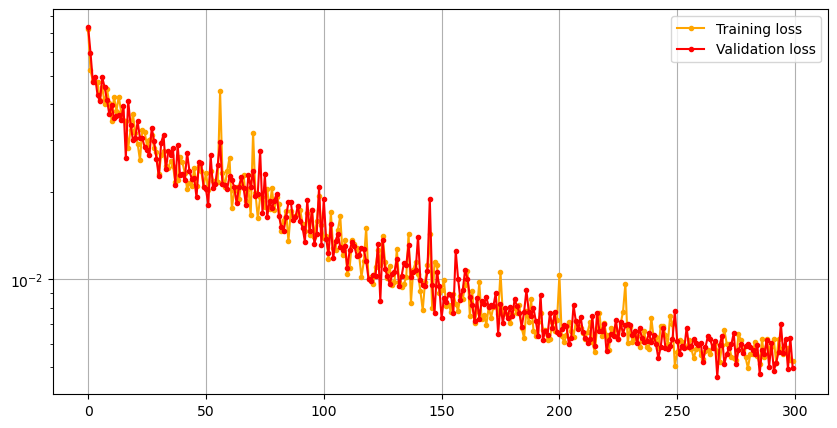

In [31]:
fig, ((ax1)) = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(10)
#ax1.set_title('Loss over epochs')
ax1.grid()
ax1.semilogy(loss_list, 'orange', marker='.',label='Training loss')
ax1.semilogy(loss_val_list, 'red', marker='.', label='Validation loss')
ax1.legend()
plt.show()

In [32]:
# Save model
model_path = f"{dataset_name}_{n_epochs}_epochs_4_layers_{neurons}_neurons_{batch_size_train}_batch_size_loss2.mdl"
torch.save(best_model.state_dict(), model_path)

In [33]:
# Save the loss trend
with open("figures/loss_data.pk","wb") as file:
    pkl.dump((loss_list, loss_val_list), file)